# Modelo probabilístico-neuronal: FastText

Comenzamos con una implementación basada en *A. Joulin, E. Grave, P. Bojanowski & T. Mikolov (2017). Bag of Tricks for Efficient Text Classification*.
Se trata  de un modelo neuronal muy simple pasado en n-gramas. Se puede entender como una generalización del modelo anterior basado en los perfiles de n-gramas que adapta esta idea al paradigma neuronal, lo que le permite (en teoría) generalizar mejor y exprimir más las características de los datos.


La idea es que de nuevo, trabajamos sobre la distribución de n-gramas, con el objetivo de poder generalizar a palabras nunca vistas. Pero en este caso, en lugar de comparar los perfiles de n-gramas de tal cual, lo que haremos será hacer un embedding de los n-gramas y promediarlo para obtener un embedding del texto. Esperamos que de esta forma podamos generalizar mejor que en el modelo anterior.

La arquitectura del modelo es muy simple, ya que no tiene ninguna capa oculta, es simplemente la capa de embedding (aprendida) y la capa softmax. La entrada de la red es una representación tipo BoW truncando el vocabulario.

**Ideas:**
- **Preprocesamiento**:

    - Minúsculas.

    - Eliminación de puntuación.

    - N-gramas de tamaño desde 1 hasta 5.

- **Representación**:

    - Se aprende un embedding de los n-gramas.
    - El embedding de la frase se obtiene como la media de los embeddings de los n-gramas.


- **Clasificador**:

    - Un modelo lineal (una capa softmax lineal) sobre la representación del texto.

- **Entrenamiento**:

    - Loss: Entropía Cruzada
        >  For a set of N documents, this leads to minimizing the negative loglikelihood over the classes
        
        Usan "hierarchical softmax" para acelerar el entrenamiento cuando el número de clases es elevado. No tenemos ese problema por lo que no lo implementamos.
    - Optimizador: SGD.



In [1]:
# Librerías necesarias
import os
import regex as re
import joblib
import pickle
import pandas as pd 
import numpy as np
from typing import List, Union
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from utils import classification_metrics_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKerasTF

## 1. Definición del modelo

Definimos la clase para el modelo FastText basándonos en el artículo mencionado. De nuevo, he optado por incluir el preprocesamiento como un método dentro de la clase (`_preprocess_texts`) al que se llama de forma automática al entrenar el modelo y hacer predicciones. De esta forma conseguimos evitar inconsistencias y queda todo mejor encapsulado. Se implementan los típicos métodos `fit` y `predict`.

In [2]:
class FastTextClassifier:
    """
    Clase con una implementación de FastText inspirada en
    A. Joulin, E. Grave, P. Bojanowski & T. Mikolov (2017). 
    Bag of Tricks for Efficient Text Classification

    Args:
    - min_n: Tamaño mínimo de los n-gramas considerados (por defecto 1)
    - max_n: Tamaño máximo de los n-gramas considerados (por defecto 5)
    - embedding_dim: Dimensión de los embeddings (por defecto 50)
    - vocab_size: Tamaño máximo del vocabulario (por defecto 5000)

    """
    def __init__(self, min_n=1, max_n=5, embedding_dim=50, vocab_size=5000):

        self.min_n = min_n
        self.max_n = max_n
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        self.ngram_vocab = {}
        self.model = None
        self.pad_id = 0 # Id para padding
        self.unk_id = 1 # Id para n-gramas fuera del vocabulario
        self.start_id = 2
        self.n_langs=None

    def _preprocess_texts(self, texts: List[str]) -> List[str]:
        """
        Preprocesamiento necesario para el modelo
        """
        cleaned_texts = []
        for text in texts:
            # Convertir a minúsculas
            text = text.lower()
            # Eliminar todo lo que no sea letra unicode, espacio o apóstrofo (dejando un espacio)
            text = re.sub(r"[^\p{L}\s']", ' ', text)
            # Eliminar guiones bajos (porque \w incluye _)
            text = re.sub(r'_', '', text)
            # Convertir espacios múltiples en uno solo
            text = re.sub(r'\s+', ' ', text).strip()

            cleaned_texts.append(text)
        return cleaned_texts

    def _generate_word_ngrams(self, word: str) -> set:
        """
        Generar todos los n-gramas de tamaño n_min a n_max para una palabra
        """
        # He visto que en algunas implementaciones se emplean indicadores 
        # de extremo de palabra para diferenciar n-gramas internos
        # de externos. Emplearemos "<>" para tal  fin.
        word = f"<{word}>"

        ngrams = set()
        for n in range(self.min_n, min(self.max_n + 1, len(word) + 1)):
            for i in range(len(word) - n + 1):
                ngram = word[i:i + n]
                if ngram not in {'<', '>'}:
                    ngrams.add(ngram)
        return ngrams

    def _build_vocab(self, texts: List[str]):
        """
        Construir nuestro vocabulario de n_gramas
        """
        ngram_freq = Counter()

        for text in texts:
            for word in text.split():
                ngrams = self._generate_word_ngrams(word)
                for ngram in ngrams:
                    ngram_freq[ngram] += 1

        # Truncamos a tamaño vocab_size quedándonos con los más frecuentes
        most_common = ngram_freq.most_common(self.vocab_size)

        # Reservamos 0 para padding y 1 para <unk>
        self.ngram_vocab = {ngram: idx + self.start_id for idx, (ngram, _) in enumerate(most_common)}

    def _encode_text(self, text: str) -> List[int]:
        """
        Codificar el texto empleando el vocabulario construido
        """
        ngram_ids = []
        for word in text.split():
            ngrams = self._generate_word_ngrams(word)
            for ng in ngrams:
                ngram_ids.append(self.ngram_vocab.get(ng, self.unk_id))
        return ngram_ids

    def _vectorize_texts(self, texts: List[str]) -> tf.Tensor:
        """
        Dada una lista de textos, codifica todos ellos y los vectoriza 
        empleando padding
        """
        encoded = [self._encode_text(text) for text in texts]
        return pad_sequences(encoded, padding='post')

    def _build_model(self):
        """
        Construir y compilar el modelo neuronal
        """
        vocab_size = len(self.ngram_vocab) + 2  # padding=0, unk=1
        
        # Definición del modelo
        inputs = tf.keras.Input(shape=(None,))
        x = layers.Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, mask_zero=True)(inputs)
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(self.n_langs, activation='softmax')(x)
        
        self.model = tf.keras.Model(inputs, outputs)
        
        # Se compila el modelo
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def fit(self, raw_texts: List[str], labels: List[int], validation: tuple[List[str],List[int]]=None, epochs=10, batch_size=32, verbose=True):
        """
        Preprocesar los textos de entrenamiento y validación y entrenar el modelo.
        """
        # Se toma el número de idiomas que haya en la muestra
        self.n_langs = len(set(labels)) 

        # Preprocesamiento
        texts = self._preprocess_texts(raw_texts)
        self._build_vocab(texts) # Construir el vocabulario
        train_sequences = self._vectorize_texts(texts)
        labels_tensor = tf.convert_to_tensor(labels)

        if validation:
            val_texts = self._preprocess_texts(validation[0])
            val_sequences = self._vectorize_texts(val_texts)
            val_labels = tf.convert_to_tensor(validation[1])
            validation = (val_sequences,val_labels)

        # Construir el modelo
        self._build_model()
        if verbose:
            self.model.summary()
        self.model.fit(train_sequences, 
                       labels_tensor, 
                       epochs=epochs, 
                       batch_size=batch_size,
                       validation_data=validation,
                       callbacks=[
                           EarlyStopping(        # EarlyStopping
                            monitor='val_accuracy',      # Monitoriza la accuracy en la validación
                            patience=5,                  # Número de épocas sin mejora antes de detener el entrenamiento
                            restore_best_weights=True),  # Devuelve los mejores pesos al finalizar
                           PlotLossesKerasTF()   # Monitorear el entrenamiento
                        ])
                

    def predict(self, raw_texts: Union[str, List[str]]) -> np.array:
        """
        Predecir un nuevo texto o lista de textos
        """
        # Si es una sola cadena, convertirla a lista temporalmente
        if isinstance(raw_texts, str):
            raw_texts = [raw_texts]
        
        # Preprocesamiento
        texts = self._preprocess_texts(raw_texts)
        sequences = self._vectorize_texts(texts)

        # Predicción
        predictions = self.model.predict(sequences)
        
        return predictions

Posibles mejoras:
- `_encode_texts` no limita el tamaño del texto y luego `pad_sequences `se queda con el tamaño máximo. Bastaría añadir el especificar `max_len` en `pad_sequences`.
- Se podría indicar el número de idiomas como parámetro de entrada de la clase. Por defecto te coge los que haya en tu conjunto de entrenamiento
- Estrategia a la hora de construir el vocabulario estrategia tipo tfidf
- Considerar min_n 3 (una letra sola tiene tamaño 3, por ejemplo "\<a\>") y las letras sueltas no nos ayudan, en general a diferenciar idiomas. (A menos que sea un alfabeto característico). En realidad, si es neceario añadir letras sueltas. Por ejemplo, la ñ te discrimina el español directamente.

## 2. Aplicación del modelo

### Lectura y prepraración de los datos
Comenzamos leyendo las particiones de entrenamiento, validación y test que habíamos creado previamente. 

In [3]:
# Leemos los datos
df_train = pd.read_csv(os.path.join("data","raw","train.csv"))
df_val = pd.read_csv(os.path.join("data","raw","val.csv"))
df_test = pd.read_csv(os.path.join("data","raw","test.csv"))

# Veamos nuestro DataFrame
df_train.head(5)

# Separamos las variables que usaremos
train_texts = df_train["text"]
val_texts = df_val["text"]
test_texts = df_test["text"]

y_train = df_train["language"]
y_val = df_val["language"]
y_test = df_test["language"]

# Codificamos la variable objetivo
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

### Entrenamiento del modelo
Definimos y entrenamos el modelo. Dado que hemos incluido el preprocesamiento dentro del modelo, no tenemos que preocuparnos por hacerlo previamente (tan solo codificar el target).

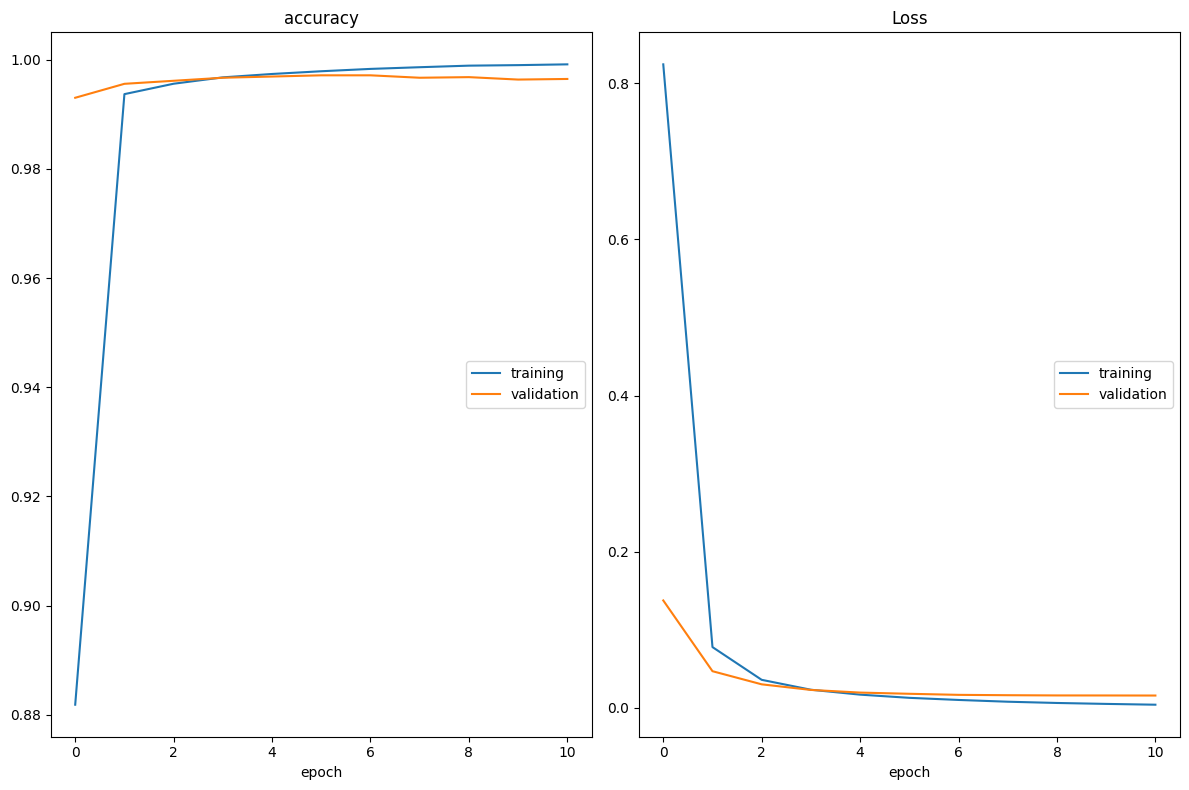

accuracy
	training         	 (min:    0.882, max:    0.999, cur:    0.999)
	validation       	 (min:    0.993, max:    0.997, cur:    0.996)
Loss
	training         	 (min:    0.004, max:    0.824, cur:    0.004)
	validation       	 (min:    0.016, max:    0.138, cur:    0.016)
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9964 - val_loss: 0.0159


In [60]:
# Definimos el modelo 
fasttext = FastTextClassifier(vocab_size=10000, min_n=1, max_n=6)

# Lo entrenamos
X_train = fasttext.fit(train_texts,y_train_enc, validation=(val_texts,y_val_enc), epochs=15)

Podemos ver con más detalle el modelo neuronal

In [61]:
fasttext.model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 50)  │    500,100 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 50)        │          0 │ embedding_3[0][0… │
│ (GlobalAveragePool… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12)        │        612 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,502,138 (5.73 MB)

 Trainable params: 500,712 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,001,426 (3.82 MB)

Vamos a guardar el modelo entrenado

In [62]:
# Creamos el directorio si no existe
fasttext_dir = os.path.join("models","fasttext")
os.makedirs(fasttext_dir, exist_ok=True)

# Guardamos el modelo entrenado
joblib.dump(fasttext, os.path.join(fasttext_dir,'fasttext_model.joblib'))

['models\\fasttext\\fasttext_model.joblib']

### Evaluación del modelo
Empleamos el modelo para hacer predicciones sobre el conjunto de test y evaluamos su rendimiento

In [63]:
import time

# Hacemos las predicciones monitoreando la latencia del modelo
start = time.time()
preds = fasttext.predict(test_texts)
end = time.time()

preds_class = preds.argmax(axis = 1)
preds_str = le.inverse_transform(preds_class)

# Empleamos una función personalizada para ver un report del rendimiento
results_fasttext = classification_metrics_report(y_test, preds_str, df_test["n_words"])

# Latencia
latency_ms = (end - start) * 1000  # milisegundos
print(f"Latencia: {latency_ms:.2f} ms")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.996112         0.996114      0.996086  0.996097

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   0.998609 0.994460 0.996530      722
   da   0.994638 0.994638 0.994638      746
   de   0.996063 0.996063 0.996063      762
   el   1.000000 1.000000 1.000000      733
   es   0.994483 0.991747 0.993113      727
   fi   1.000000 1.000000 1.000000      785
   fr   0.992157 1.000000 0.996063      759
   it   0.993280 0.997301 0.995286      741
   pl   0.997271 0.993207 0.995235      736
   pt   0.994695 0.994695 0.994695      754
   sl   0.995951 0.995951 0.995951      741
   sv   0.996222 0.994969 0.995595      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  1.000000         1.000000      1.000000  1.000000
medium  0.998663         0.998659      0.998628  0.998642
 small  0.983671         0.983283  

Este modelo es la caña y el entrenamiento es rapidísimo

### Análisis de errores

In [64]:
def sorted_dict_probs(pred_probs:np.array):
    
    return dict(sorted(zip(le.classes_,np.round(pred_probs,3)), key=lambda x: x[1], reverse=True))

In [65]:
# Nos centramos en los errores
df_errors = df_test[preds_class!=y_test_enc].copy()

# Añadimos la clase predicha
df_errors.loc[:,"pred"] = [pred for pred, true in zip(preds_str, y_test) if pred != true]

# Añadimos las probabilidades
df_errors.loc[:,"scores"] = [sorted_dict_probs(preds[i]) for i in range(len(test_texts)) if preds_str[i]!=y_test[i]]

# Añadimos la frase preprocesada
df_errors.loc[:,"preprocessed_text"] = [fasttext._preprocess_texts([text])[0] for i, text in enumerate(test_texts) if preds_str[i]!=y_test[i]]

# Veamos los errores
df_errors

,text,language,n_words,pred,scores,preprocessed_text
251,9. Ergebnisse des Kopenhagener Klimagipfels (\n,de,4,da,"{'da': 0.748, 'de': 0.127, 'sv': 0.064, 'fr': ...",ergebnisse des kopenhagener klimagipfels
387,É anti-social.\n,pt,3,it,"{'it': 0.687, 'pt': 0.312, 'fr': 0.001, 'sv': ...",é anti social
394,"(La sesión, suspendida a las 13.10 horas, se r...",pl,11,es,"{'es': 1.0, 'cs': 0.0, 'da': 0.0, 'de': 0.0, '...",la sesión suspendida a las horas se reanuda a ...
630,Dlatego Parlament bije na alarm.\n,pl,5,sl,"{'sl': 0.642, 'pl': 0.278, 'pt': 0.023, 'cs': ...",dlatego parlament bije na alarm
2112,(The sitting closed at 16.35)\n,sl,4,sv,"{'sv': 0.421, 'da': 0.382, 'de': 0.062, 'fi': ...",the sitting closed at
2133,I vilket syfte?\n,sv,3,da,"{'da': 0.544, 'sv': 0.455, 'cs': 0.0, 'de': 0....",i vilket syfte
2375,Citat slut.\n,da,2,fr,"{'fr': 0.684, 'sv': 0.277, 'it': 0.011, 'fi': ...",citat slut
2524,Erstens die Frage des price improvement.\n,de,6,fr,"{'fr': 0.611, 'de': 0.368, 'da': 0.017, 'es': ...",erstens die frage des price improvement
2578,(Posiedzenie zostało otwarte o godz.\n,pt,5,pl,"{'pl': 0.837, 'sl': 0.108, 'cs': 0.045, 'pt': ...",posiedzenie zostało otwarte o godz
2597,Je to ostuda.\n,cs,3,sl,"{'sl': 0.775, 'cs': 0.209, 'pt': 0.015, 'pl': ...",je to ostuda


**Errores inevitables:**
- El dataset original contiene errores: 
    - "(La sesión, suspendida a las 13.10 horas, se reanuda a las 15.00 horas)" aparece como polaco.
    - "(The sitting closed at 16.35) parece como esloveno
    - "Program Marco Polo II (" aparece como checo.
    - "because [he has] nothing else here for you," aparece como esloveno.
- Frases comunes en distintas lenguas:
    - "Al contrario!" aparece como italiano, pero podría ser español. Diferencia en el uso de los signos de puntuació en los distintos idiomas.
    - "É anti-social." aparece como portugués, pero podría ser italiano ya que se escribe igual.

**Errores graves:**
- "Permítanme que les explique tres de ellas." la clasifica como francés, cuando no hay duda de que es español. Solamente la primera palabra ya lo evidencia.
- "Formulerei dunque alcune domande.", lo clasifica como francés, cuando realmente es italiano.
- "¡Qué vergüenza!", es español y lo clasifica como portugués. Los singos de puntuación, el qué (con tilde) y la palabra vergüenza con la diéresis, no existen en portugúes, sería "que vergonha".
- "A catástrofe no Reino Unido é já enorme." es portuguesa y la predice como español. Simplemente el uso del artículo "A" al comienzo de la frase ya nos indica que no podría ser español, más aun el "é" y el "já".

**Errores curiosos:**
- "Teroristi, morilci in komunisti!" la clasifica como italiano cuando es esloveno. Unaa persona que no supiese nada de esloveno ni de italiano, podría pensar también que es italiano, pues contiene terminaciones típicas en este idioma -isti, -ci. Sin embargo, alguien que sepa un poco de italiano sabría que ninguna de esas palabras, salvo el "in" existe en italiano, por lo que no cometería el error.

**Conclusiones:**

El modelo funciona muy bien y tiene una latencia reducida. Es, sin duda, útil. Sin embargo, comete errores propios de la forma en la que está construido, basándose solo en los n-gramas más comunes. Digamos que funciona como una persona que no sabe ningún idioma y solo tiene una intuición de "fonemas" característicos en cada uno de ellos. Sin embargo, comete errores que una persona que tuviese un mínimo conocimiento de estas lenguas no cometería, derivados de que solo se fija en los n-gramas y no tiene ningún mecanismo de atención, propio en los humanos. Al intentar detectar el idioma de un texto, hay n-gramas que nos determinan completamente el idioma. Sin embargo, el modelo puede fallar en estos si hay otros muchos n-gramas que son comunes con otras lenguas. Además, dado que el modelo no contiene palabras completas, no puede discriminar si un término existe en un idioma o no. Esto se hace notar, especialmente, al aplicar el modelo sobre frases cortas.

Podríamos decir que el modelo se fija demasiado en los detalles y carece de una visión global.

### Pruebas
Hacemos algunas pruebas para ver el funcionamiento del modelo

In [66]:
text= "Hola buenos días" # Español
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Idioma detectado: es


,pred_probs
cs,0.01
da,0.00
de,0.00
el,0.00
es,0.99
fi,0.00
fr,0.00
it,0.00
pl,0.00
pt,0.01


In [67]:
text= "Cómo" # Español
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Idioma detectado: pt


,pred_probs
cs,0.01
da,0.00
de,0.00
el,0.00
es,0.09
fi,0.00
fr,0.00
it,0.01
pl,0.14
pt,0.74


Cómo no es una palabra en portugués pero incómodo sí, y aparece muchas veces. Veamos qué está pasando.

In [68]:
text = 'Cómo'
tex_preprocessed = fasttext._preprocess_texts([text])
n_grams = fasttext._generate_word_ngrams(tex_preprocessed[0])
n_grams

{'<c',
 '<có',
 '<cóm',
 '<cómo',
 '<cómo>',
 'c',
 'có',
 'cóm',
 'cómo',
 'cómo>',
 'm',
 'mo',
 'mo>',
 'o',
 'o>',
 'ó',
 'óm',
 'ómo',
 'ómo>'}

In [69]:
for ng in n_grams:
    if ng in fasttext.ngram_vocab.keys():
        print(ng)

o>
mo
<c
c
mo>
o
ó
m


Los n-gramas que caracterizan a "Cómo" como una palabra española, que serían "<có", "<cóm", "<cómo" no están en el vocabulario (ni siquiera ampliando el vocabulario a 10000). Una estrategia para solucionar esto podría ser algo así como TF-IDF a la hora de elegir el vocabulario.

In [70]:
text = "Nicht" # Alemán 
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Idioma detectado: de


,pred_probs
cs,0.0
da,0.0
de,1.0
el,0.0
es,0.0
fi,0.0
fr,0.0
it,0.0
pl,0.0
pt,0.0


In [71]:
text = "Ça ne marche pas" # Francés 
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Idioma detectado: fr


,pred_probs
cs,0.00
da,0.00
de,0.00
el,0.00
es,0.00
fi,0.00
fr,0.78
it,0.01
pl,0.00
pt,0.21


In [72]:
text = "Ça ne marche pas, je suis desolé" # Francés 
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Idioma detectado: fr


,pred_probs
cs,0.00
da,0.00
de,0.00
el,0.00
es,0.00
fi,0.00
fr,0.97
it,0.00
pl,0.00
pt,0.02


In [73]:
text = "Det fungerar inte." # Sueco
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Idioma detectado: sv


,pred_probs
cs,0.0
da,0.0
de,0.0
el,0.0
es,0.0
fi,0.0
fr,0.0
it,0.0
pl,0.0
pt,0.0


## 3. Mejora del modelo

Hemos visto que una debilidad del modelo es la construcción del vocabulario, ya que se cogen los n-gramas más frecuentes pero no los más característicos. Vamos a intentar mejorar este aspecto.

In [74]:
class FastTextProClassifier:
    """
    Clase con una implementación de FastText inspirada en
    A. Joulin, E. Grave, P. Bojanowski & T. Mikolov (2017). 
    Bag of Tricks for Efficient Text Classification

    Args:
    - min_n: Tamaño mínimo de los n-gramas considerados (por defecto 1)
    - max_n: Tamaño máximo de los n-gramas considerados (por defecto 5)
    - embedding_dim: Dimensión de los embeddings (por defecto 50)
    - vocab_size: Tamaño máximo del vocabulario (por defecto 5000)

    """
    def __init__(self, min_n=1, max_n=5, embedding_dim=50, vocab_size=5000):

        self.min_n = min_n
        self.max_n = max_n
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        self.ngram_vocab = {}
        self.model = None
        self.pad_id = 0 # Id para padding
        self.unk_id = 1 # Id para n-gramas fuera del vocabulario
        self.start_id = 2
        self.n_langs=None

    def _preprocess_texts(self, texts: List[str]) -> List[str]:
        """
        Preprocesamiento necesario para el modelo
        """
        cleaned_texts = []
        for text in texts:
            # Convertir a minúsculas
            text = text.lower()
            # Eliminar todo lo que no sea letra unicode, espacio o apóstrofo (dejando un espacio)
            text = re.sub(r"[^\p{L}\s']", ' ', text)
            # Eliminar guiones bajos (porque \w incluye _)
            text = re.sub(r'_', '', text)
            # Convertir espacios múltiples en uno solo
            text = re.sub(r'\s+', ' ', text).strip()

            cleaned_texts.append(text)
        return cleaned_texts

    def _generate_word_ngrams(self, word: str) -> set:
        """
        Generar todos los n-gramas de tamaño n_min a n_max para una palabra
        """
        # He visto que en algunas implementaciones se emplean indicadores 
        # de extremo de palabra para diferenciar n-gramas internos
        # de externos. Emplearemos "<>" para tal  fin.
        word = f"<{word}>"

        ngrams = set()
        for n in range(self.min_n, min(self.max_n + 1, len(word) + 1)):
            for i in range(len(word) - n + 1):
                ngram = word[i:i + n]
                if ngram not in {'<', '>'}:
                    ngrams.add(ngram)
        return ngrams

    def _build_vocab(self, texts: List[str], labels: List[int]):
        """
        Construir vocabulario usando una puntuación discriminativa:
        max_freq_por_idioma / media_de_frecuencias
        """
        from collections import defaultdict
        import numpy as np

        # Inicializa un diccionario: idioma -> Counter de ngramas
        lang_ngram_freq = defaultdict(Counter)

        # Recorremos cada texto y su etiqueta
        for text, label in zip(texts, labels):
            for word in text.split():
                ngrams = self._generate_word_ngrams(word)
                for ng in ngrams:
                    lang_ngram_freq[label][ng] += 1

        # ngram -> lista de frecuencias por idioma
        ngram_stats = defaultdict(lambda: [0] * self.n_langs)
        for lang_id, counter in lang_ngram_freq.items():
            for ng, freq in counter.items():
                ngram_stats[ng][lang_id] = freq

        # Calcular puntuaciones para cada n-grama
        alpha = 0.5
        ngram_scores = {}
        for ng, freqs in ngram_stats.items():
            freqs_arr = np.array(freqs)
            mean = freqs_arr.mean()
            max_freq = freqs_arr.max()
            # score = max_freq / (mean + 1e-6)  # evitar división por 0
            score = (max_freq / (mean + 1e-6)) * np.log1p(freqs_arr.sum()) # Favorecer la frecuencia
            # score = alpha * (max_freq / (mean + 1e-6)) + (1 - alpha) * freqs_arr.sum()
            ngram_scores[ng] = score

        # Seleccionar los top-n con mayor score
        top_ngrams = sorted(ngram_scores.items(), key=lambda x: x[1], reverse=True)[:self.vocab_size]

        # Asignar IDs a los ngramas seleccionados
        self.ngram_vocab = {ngram: idx + self.start_id for idx, (ngram, _) in enumerate(top_ngrams)}


    def _encode_text(self, text: str) -> List[int]:
        """
        Codificar el texto empleando el vocabulario construido
        """
        ngram_ids = []
        for word in text.split():
            ngrams = self._generate_word_ngrams(word)
            for ng in ngrams:
                ngram_ids.append(self.ngram_vocab.get(ng, self.unk_id))
        return ngram_ids

    def _vectorize_texts(self, texts: List[str]) -> tf.Tensor:
        """
        Dada una lista de textos, codifica todos ellos y los vectoriza 
        empleando padding
        """
        encoded = [self._encode_text(text) for text in texts]
        return pad_sequences(encoded, padding='post')

    def _build_model(self):
        """
        Construir y compilar el modelo neuronal
        """
        vocab_size = len(self.ngram_vocab) + 2  # padding=0, unk=1
        
        # Definición del modelo
        inputs = tf.keras.Input(shape=(None,))
        x = layers.Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, mask_zero=True)(inputs)
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(self.n_langs, activation='softmax')(x)
        
        self.model = tf.keras.Model(inputs, outputs)
        
        # Se compila el modelo
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def fit(self, raw_texts: List[str], labels: List[int], validation: tuple[List[str],List[int]]=None, epochs=10, batch_size=32, verbose=True):
        """
        Preprocesar los textos de entrenamiento y validación y entrenar el modelo.
        """
        # Se toma el número de idiomas que haya en la muestra
        self.n_langs = len(set(labels)) 

        # Preprocesamiento
        texts = self._preprocess_texts(raw_texts)
        self._build_vocab(texts, labels) # Construir el vocabulario
        train_sequences = self._vectorize_texts(texts)
        labels_tensor = tf.convert_to_tensor(labels)

        if validation:
            val_texts = self._preprocess_texts(validation[0])
            val_sequences = self._vectorize_texts(val_texts)
            val_labels = tf.convert_to_tensor(validation[1])
            validation = (val_sequences,val_labels)

        # Construir el modelo
        self._build_model()
        if verbose:
            self.model.summary()
        self.model.fit(train_sequences, 
                       labels_tensor, 
                       epochs=epochs, 
                       batch_size=batch_size,
                       validation_data=validation,
                       callbacks=[
                           EarlyStopping(        # EarlyStopping
                            monitor='val_accuracy',      # Monitoriza la accuracy en la validación
                            patience=5,                  # Número de épocas sin mejora antes de detener el entrenamiento
                            restore_best_weights=True),  # Devuelve los mejores pesos al finalizar
                           PlotLossesKerasTF()   # Monitorear el entrenamiento
                        ])
                

    def predict(self, raw_texts: Union[str, List[str]]) -> np.array:
        """
        Predecir un nuevo texto o lista de textos
        """
        # Si es una sola cadena, convertirla a lista temporalmente
        if isinstance(raw_texts, str):
            raw_texts = [raw_texts]
        
        # Preprocesamiento
        texts = self._preprocess_texts(raw_texts)
        sequences = self._vectorize_texts(texts)

        # Predicción
        predictions = self.model.predict(sequences)
        
        return predictions

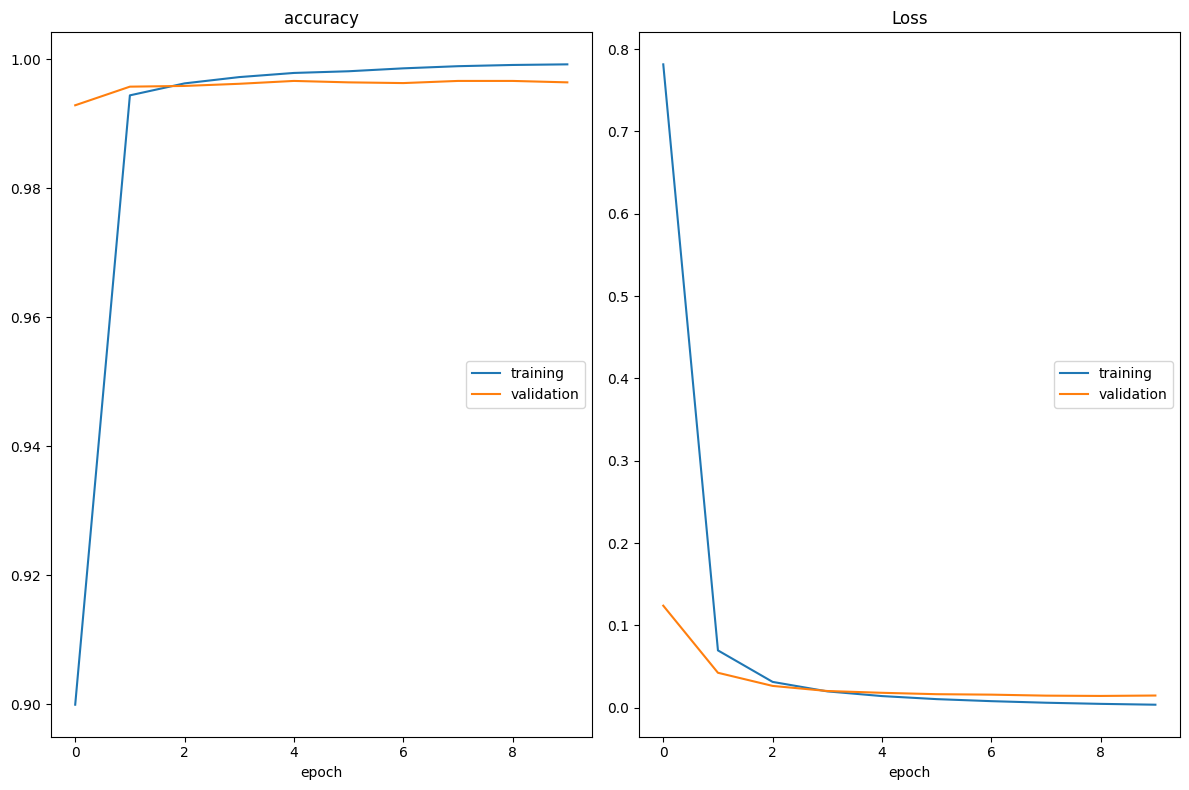

accuracy
	training         	 (min:    0.900, max:    0.999, cur:    0.999)
	validation       	 (min:    0.993, max:    0.997, cur:    0.996)
Loss
	training         	 (min:    0.004, max:    0.781, cur:    0.004)
	validation       	 (min:    0.014, max:    0.124, cur:    0.015)
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.9964 - val_loss: 0.0149


In [75]:
# definimos el modelo 
fasttextpro = FastTextClassifier(vocab_size=15000, min_n=1, max_n=6)

# Lo entrenamos
fasttextpro.fit(train_texts,y_train_enc, validation=(val_texts,y_val_enc), epochs=30)

In [76]:
fasttextpro.ngram_vocab
# Ahora se está fijando en los ngramas raros, de hecho demasiado

{'e': 2,
 'a': 3,
 'i': 4,
 'n': 5,
 'o': 6,
 's': 7,
 't': 8,
 'r': 9,
 'd': 10,
 'l': 11,
 'm': 12,
 'e>': 13,
 'u': 14,
 'p': 15,
 'a>': 16,
 'c': 17,
 'v': 18,
 'en': 19,
 'k': 20,
 'n>': 21,
 '<d': 22,
 'g': 23,
 'o>': 24,
 '<p': 25,
 'h': 26,
 '<s': 27,
 'de': 28,
 'er': 29,
 's>': 30,
 'st': 31,
 'j': 32,
 't>': 33,
 'te': 34,
 'r>': 35,
 'b': 36,
 '<e': 37,
 'z': 38,
 'i>': 39,
 'es': 40,
 '<a': 41,
 're': 42,
 'in': 43,
 'an': 44,
 'ta': 45,
 'f': 46,
 'on': 47,
 '<t': 48,
 'ra': 49,
 'y': 50,
 'en>': 51,
 '<m': 52,
 '<de': 53,
 'is': 54,
 '<n': 55,
 'ti': 56,
 'se': 57,
 'nt': 58,
 'ar': 59,
 'α': 60,
 'ne': 61,
 '<v': 62,
 'me': 63,
 '<o': 64,
 'la': 65,
 '<i': 66,
 'ro': 67,
 'ni': 68,
 'le': 69,
 'or': 70,
 'pr': 71,
 'si': 72,
 'ie': 73,
 'et': 74,
 'ä': 75,
 'po': 76,
 '<c': 77,
 'w': 78,
 'os': 79,
 'τ': 80,
 'li': 81,
 'al': 82,
 'at': 83,
 '<l': 84,
 'to': 85,
 'it': 86,
 'el': 87,
 'ch': 88,
 'na': 89,
 '<k': 90,
 'ε': 91,
 'em': 92,
 'ι': 93,
 'ο': 94,
 'er>': 95,
 

In [77]:
# Hacemos las predicciones
preds = fasttext.predict(test_texts)
preds_class = preds.argmax(axis = 1)
preds_str = le.inverse_transform(preds_class)

# Empleamos una función personalizada para ver un report del rendimiento
results_fasttext = classification_metrics_report(y_test, preds_str, df_test["n_words"])

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Global Metrics ===
 accuracy  precision_macro  recall_macro  f1_macro
 0.996112         0.996114      0.996086  0.996097

=== Per-Class Metrics ===
label  precision   recall       f1  support
   cs   0.998609 0.994460 0.996530      722
   da   0.994638 0.994638 0.994638      746
   de   0.996063 0.996063 0.996063      762
   el   1.000000 1.000000 1.000000      733
   es   0.994483 0.991747 0.993113      727
   fi   1.000000 1.000000 1.000000      785
   fr   0.992157 1.000000 0.996063      759
   it   0.993280 0.997301 0.995286      741
   pl   0.997271 0.993207 0.995235      736
   pt   0.994695 0.994695 0.994695      754
   sl   0.995951 0.995951 0.995951      741
   sv   0.996222 0.994969 0.995595      795

=== Metrics Per Size ===
  size  accuracy  precision_macro  recall_macro  f1_macro
 large  1.000000         1.000000      1.000000  1.000000
medium  0.998663         0.998659      0.998628  0.998642
 small  0.983671         0.983283  

In [79]:
text = "Cómo" # Español 
pred_probs = fasttext.predict(text) 
df_probs = pd.DataFrame({"pred_probs":pred_probs.flatten()}, index=le.classes_)

print("Idioma detectado:", le.inverse_transform(pred_probs.argmax(axis=1))[0])
df_probs.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Idioma detectado: pt


,pred_probs
cs,0.01
da,0.00
de,0.00
el,0.00
es,0.09
fi,0.00
fr,0.00
it,0.01
pl,0.14
pt,0.74
